Критерий "устойчивости": необходимо определить такие параметры модели, при которых количество жертв и хищников на пике роста или падения отличается не более чем на 0.2 на всём интервале моделирования, где 0.2 это число, связанное с формальным параметром n, характеризующим, например модификатор численности жертв и хищников. Вопрос почему именно на пике? С одной стороны, логично в реальных условия оценивать крайние состояния системы. Например, если по упрощённой модели Вольтерра-Лотки у нас наблюдается падение числа хищников, то в какой-то момент обязательно начнётся его рост, так как это продиктовано периодичностью данной системы. Однако в реальных условиях хищников может быть на столько мало, что по естественным причинам этот вид обречён на вымирание, даже при наличии безграничного количества пищи в лице жертв. И в таком случае наибольший интерес в идеализованной модели вызовет именно значение на пике падения популяции, а не где-то в процессе него. С другой стороны, сама реализация данного критерия даст понять почему удобно оценивать именно так.

Но конечно же логичнее было бы оценивать количество в отношении, но предложенный критерий попросту будет легче идентифицировать на графике при просмотре результатов.

In [1]:
from scipy.optimize import fsolve, minimize
from sympy import symbols, log, lambdify
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def findC(alpha, beta, gamma, delta, x0, y0):
    return(delta*x0 + beta*y0 - gamma*math.log(x0) - alpha*math.log(y0))

#symbolic
def symF(x, y, alpha, beta, gamma, delta, C): 
    f = delta*x + beta*y - gamma*log(x) - alpha*log(y) - C
    return f

def mark(parameters):
    alpha = parameters[0]
    beta  = parameters[1]
    gamma = parameters[2]
    delta = parameters[3]

    tolerance = 0.2
    x0 = 1
    y0 = 1
         
    C = findC(alpha, beta, gamma, delta, x0, y0)
    
    xlimit = gamma/delta
    ylimit = alpha/beta
    
    x = symbols('x')
    y = symbols('y')
    f = symF(x, y, alpha, beta, gamma, delta, C)
    
    fy = f.subs(x, xlimit)
    fx = f.subs(y, ylimit)
    
    l = lambdify(y, fy, "math")
    y1 = fsolve(l, 0.001)
    y2 = fsolve(l, 2*ylimit)

    l = lambdify(x, fx, "math")
    x1 = fsolve(l, 0.001)
    x2 = fsolve(l, 2*xlimit)
    
    maxShift = max(abs(xlimit - y1), abs(xlimit - y2), abs(ylimit - x1), abs(ylimit - x2))
    return(abs(maxShift - tolerance))

In [3]:
solution = minimize(mark, [1, 1, 1, 1])
print("alpha = ", round(solution.x[0], 6))
print("beta =  ", round(solution.x[1], 6))
print("gamma = ", round(solution.x[2], 6))
print("delta = ", round(solution.x[3], 6))

alpha =  1.281257
beta =   1.120817
gamma =  1.281257
delta =  1.120817


In [4]:
class Biome(object):
    def __init__(self, pred_init=1, prey_init=1, tmax=10, dt=0.0001):
        self._dt = dt
        self._n_iters = int(tmax / dt)
        # Intial state
        self.pred_init = pred_init
        self.prey_init = prey_init
        # Data arrays
        self.time = None
        self.prey = None
        self.pred = None

    def run(self, alpha, beta, gamma, delta):
        """
        Simulation settings:
            alpha - prey growth
            beta - prey mortality
            delta - predator growrh
            gamma - predator mortality
        """
        self.time = np.zeros(self._n_iters)
        self.prey = np.zeros(self._n_iters)
        self.pred = np.zeros(self._n_iters)
        self.prey[0] = self.prey_init
        self.pred[0] = self.pred_init
        # Lotka-Volterra equations
        for i in range(self._n_iters - 1):
            self.prey[i + 1] = self.prey[i] + self._dt * self.prey[i] * (alpha - self.pred[i] * beta)
            self.pred[i + 1] = self.pred[i] + self._dt * self.pred[i] * (delta * self.prey[i] - gamma)
        self.time[1:] = np.add.accumulate([self._dt] * (self._n_iters - 1))
        return self.time, self.prey, self.pred

    def plot(self):
        plt.xlabel('time')
        plt.ylabel('n')
        plt.plot(self.time, self.pred, label='predators', color='r')
        plt.plot(self.time, self.prey, label='preys', color='b')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_cycle(self):
        plt.xlabel('n predators')
        plt.ylabel('n preys')
        plt.plot(self.pred, self.prey, color='black')
        plt.grid()
        plt.show()

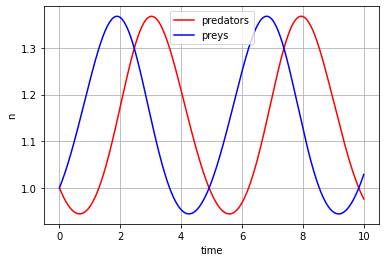

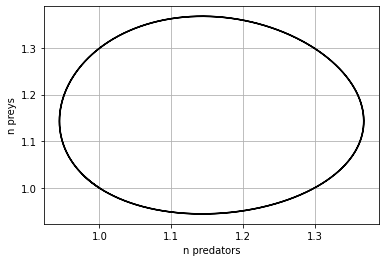

In [5]:
biome = Biome(tmax=10)
#biome.run(2, 5, 2, 2)
biome.run(solution.x[0], solution.x[1], solution.x[2], solution.x[3])
biome.plot()
biome.plot_cycle()

Возможно, следует пояснить что тут вообще происходит. Пусть в наших рассуждениях x(t) будет количеством жертв в момент времени t, а y(t) количеством хищников. Если рассматривать данную модель как стационарную, то при любых x и y больших 0 на всём временном интервале верно следующее (я буду знак умножения указывать как ".", так как в gitLab почему-то некорректно отображается экранирование символов):

Alpha.x – Beta.x.y = 0

-Gamma.y + Delta.x.y = 0

И преобразовав эти уравнения получим:

x = Gamma/Delta

y = Alpha/Beta

Зачем нам это так важно. Дело в том, что получившиеся координаты x и y будут является координатами особой точки (а точнее фокуса) фазовой траектори, отражающей количество жертв и хищников. Поясню, особая точка векторного поля является положением равновесия или точкой покоя динамической системы, определяемой данным векторным полем (в нашем случае мы имеем дело с одной траекторией вектроного поля). Дело в том, что если провести горизонтальную и вертикальную линии через данную точку, то они пересекут траекторию на фазовой плоскости в крайних точках. Если соотнести это с временной диаграммой, то видна чёткая взаимосвязь. Теперь я думаю уже становится чуть более понятно почему оценка производиться именно на пике роста и падения. Но это ещё не всё. Для данной модели можно вывести аналитическое уравнение.

Если взять и поделить dy/dt на dx/dt, выполнив небольшое преобразование можно получить следующий вид уравнения:

y.(Delta.x - Gamma).dx + x.(Beta.y - Alpha).dy = 0

Из подобного уравнения довольно просто исключить знаки дифференциала, разделив всё уравнение на x.y и проинтегрировав оба слагаемых применив метод разделяющихся переменных. И в итоге получим:

Delta.x + Beta.y – Gamma.ln(|x|) – Alpha.ln(|y|) = C, где C – некоторая неизвестная константа.

И эта константа постоянна для заданных параметров и любых x и y. Это можно легко проверить, просто подставив уже рассчитанные численно значения x и y. Результат для них будет равен C или близким к нему, так как численное решение вносит ошибки дискретизации временной шкалы. Да, это было проверено и подтверждено, но останавливаться на этом не будем.

Казалось бы, ну и что это нам даёт? C ведь в общем случае неизвестно. Значит всё, тупик? Нет, всё складывается даже лучше, чем можно было себе представить. Дело в том, что для модели Вольтерра-Лотки предусмотрены начальные условия в виде начального количества хищников и жертв. Пусть их количество одинаково и выражается формальным значением 1. Тогда для заданных параметров и исходных условий можно расчитать C. А теперь вернёмся назад и вспомним про точки пересечения проведённых линий и графика на фазовой плоскости. Мы знаем их координаты. А точнее одну из них. Мы можем подставить одну известную координату и для уже рассчитанного С определить неизвестную: 

Delta.x + Beta.y – Gamma.ln(|x|) – Alpha.ln(|y|) = C, где Alpha, Beta, Gamma, Delta, C и (x или y) известны. 

Эта задача сводится к поиску корней уравнения, которая уже решается методом библиотеки python. И думаю достаточно логично, что такое уравнение будет имеет два вещественных корня. Выполнив подобный расчёт для каждой известной координаты мы получим полный набор координат точек пересечения на фазовой плоскости. И эти величины будут характеризовать количество жертв и хищников в каждый момент времени, когда численность тех или других достигает своего пика. Таких пиков в пределах одного периода как уже можно догадается ровно четыре. Теперь задача сводится к тому, чтобы расчитать для заданных параметров оценку соответствия критерю устойчивости. Задача минимизатора уже определить такие параметры модели, при которых оценка будет равена нулю, то есть полностью соответствовать граничному значению условия. И это тоже выполняется средствами python.


Дополнительное задание:

Ну говоря о методике оценки влияния параметров на критерий, то думаю уравнения:

x = Gamma/Delta

y = Alpha/Beta

и

Delta.x + Beta.y – Gamma.ln(|x|) – Alpha.ln(|y|) = C

говорят сами за себя. Тут на самом деле важны не абсолютные значения параметров, а значения относительно друг друга. Ну и если понаблюдать за изменением временной диаграммы можно сделать вывод о том, что при

Alpha/Beta = Gamma/Delta

достигается симметричность графиков относительно оси количества и лучшая минимизация. Что касается лучшей минимизации, то минимизатор в этом мнении со мной полностью солидарен.

Ну а так в принципе можно просто посмотреть на влияние каждого параметра на модель в отдельности. Это допустимо, так как уже было сказано ранее что для системы имеет большую значимость относительное значение параметров, а не абсолютное. И для простоты мы сделаем отношение соответствующих параметров одинаковым, так как мы уже знаем, что это наиболее оптимально с точки зрения соблюдения критерия устойчивости.  Самое простое, осуществить это методом перебора, применимым практически для любого анализа.

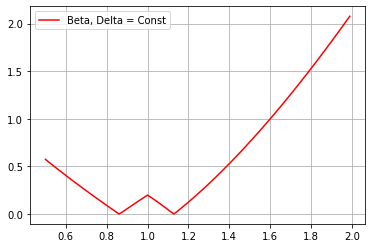

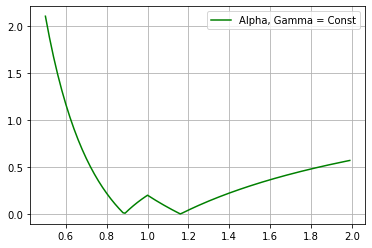

In [6]:
X = []
Y = []

for a in range(50, 200):
    X.append(a/100)
    par = [a/100, 1, a/100, 1]
    Y.append(mark(par))
    
plt.plot(X, Y, label="Beta, Delta = Const", color='r')
plt.legend()
plt.grid()
plt.show()

X.clear()
Y.clear()

for b in range(50, 200):
    X.append(b/100)
    par = [1, b/100, 1, b/100]
    Y.append(mark(par))
    
plt.plot(X, Y, label="Alpha, Gamma = Const", color='g')
plt.legend()
plt.grid()
plt.show()
                